<h1> Preprocessing </h1>

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import time
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime


#%pip install --upgrade scikit-learn
#%pip install --upgrade imbalanced-learn

from imblearn.over_sampling import RandomOverSampler


In [2]:
train_data = pd.read_csv('data/fraudTrain.csv')
test_data = pd.read_csv('data/fraudTest.csv')

train_data['is_train'] = 1
test_data['is_train'] = 0

In [3]:
split = train_data.size
data = pd.concat([train_data, test_data])

In [4]:
data.tail()
test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,is_train
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,0


In [5]:
def encode_labels(df, column_name):
    le = preprocessing.LabelEncoder()
    data[column_name] = le.fit_transform(df[column_name])
    return data

def encode_onehot(df, column_name):
    return pd.get_dummies(df, columns=[column_name])

def minmax_scale(df, column_name):
    scaler = preprocessing.MinMacScaler()
    data = scaler.fit_transform(df[column_name])
    return scaler, data

In [6]:
def convert_epoch(df, column_name):
    for name, value in df[column_name].iteritems():
        value = time.strptime(value)
    return df[column_name]
    
def convert_utc(df, column_name):
    for name, value in df[column_name].iteritems():
        value = time.gmtime(value)
    return df[column_name]

In [7]:
def oversampling(df, column_name):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=0)
    X = df.drop(column_name, axis=1)
    y = df[column_name]
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=column_name)], axis=1)
    return resampled_df

In [8]:
def calculateAgeWithDateOfBirth(df,column_name):
    #df[column_name]= df[column_name].strftime(df[column_name],'%Y-%m-%d').date()
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d')
    #df[column_name] = pd.to_datetime(df[column_name].dt.strftime('%Y-%m-%d'))
    print(type(df[column_name].iloc[1]))
    #current_date= datetime.now()
    current_date= pd.to_datetime(date.today())
    print(type(df[column_name].iloc[1]))
    print(df[column_name].iloc[1])
    
    df['age_in_years'] = (current_date - df[column_name]) // pd.Timedelta(365, 'D')
    df['age_in_years'] = df['age_in_years'].map(lambda x: int(x))
    return df

In [9]:
def makeGenderBinary(df, gender_column):
    df[gender_column]=df[gender_column].map(lambda x: 1 if x == 'M' else 0)
    return df

def convert_to_unixtime(df, datetime_column):

    df['unix_time'] = pd.to_datetime(df[datetime_column]).astype(int) // 10**9
    return df

In [10]:
def splitDateAndTime(data,date_and_time_col):
    data[date_and_time_col] = pd.to_datetime(data[date_and_time_col])
    data['trans_date'] = data[date_and_time_col].dt.strftime('%Y-%m-%d')
    data['trans_date'] = pd.to_datetime(data['trans_date'])
    data['trans_time'] =data[date_and_time_col].dt.time
    return data

In [11]:
def reduceDataWithPCA(data, components):
    from sklearn.decomposition import PCA
    reduced_data = pd.DataFrame(PCA(n_components=components).fit_transform(data))
    reduced_data.columns = ["PC"+str(i+1) for i in range(components)]
    return reduced_data

In [12]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'is_train'],
      dtype='object')

In [13]:

## Cleaning the data and feature engineering

data = calculateAgeWithDateOfBirth(data,'dob')
data = makeGenderBinary(data, 'gender')

## if you want to over sample then don't uncomment these lines, the oversampler can not handle so many col
#data = encode_onehot(data,'job')
#data = encode_onehot(data,'category')
#data = splitDateAndTime(data,'trans_date_trans_time')
data = data.drop(columns=['Unnamed: 0','first','last','dob','city','street','state','trans_date_trans_time','trans_num','merchant','job','cc_num'])


## Splitting the data back to train and test after feature engineering and cleanup
train_cleaned = data[data['is_train']==1].drop(columns=['is_train'])
test_cleaned = data[data['is_train']==0].drop(columns=['is_train'])

print(len(train_cleaned), len(test_cleaned))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
1978-06-21 00:00:00
1296675 555719


<h1> Training models </h1>

In [14]:
## RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

## Oversampling the data
oversampled_train = oversampling(train_cleaned,'is_fraud')
oversampled_train['is_fraud'].value_counts()
oversampled_train = encode_onehot(oversampled_train,'category')

oversampled_train_labels = oversampled_train['is_fraud']
oversampled_train_data = oversampled_train.drop(columns=['is_fraud'])

X_train, X_test, y_train, y_test = train_test_split(oversampled_train_data,oversampled_train_labels,test_size=0.3,train_size=0.7,random_state=5)

rf_1 = RandomForestClassifier(n_estimators=3, max_depth=5, random_state=0).fit(X_train, y_train)


C:\Users\maare\AppData\Local\Temp\ipykernel_7568\3620977419.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
C:\Users\maare\AppData\Local\Temp\ipykernel_7568\3620977419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 0)) / np.sum(y_val == 0), axis=1)


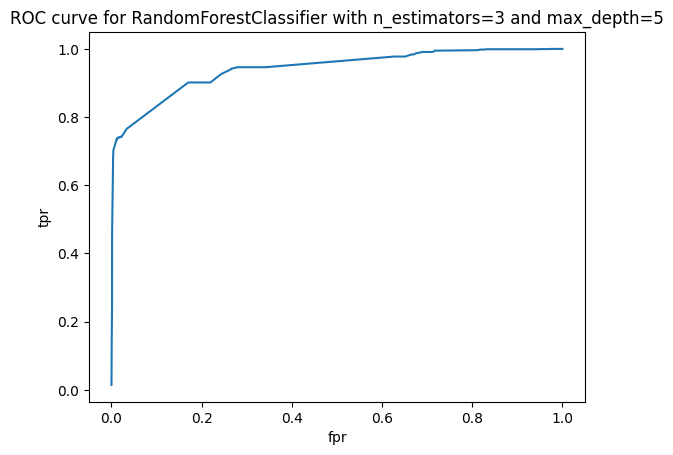

Accuracy of rf_1 model on validation data from test_train_split:  0.8665549668908419
Accuracy of rf_1 model on test data from the separate file:  0.9804325567418065


In [15]:
### ROC curve of rf_1

##One hot encoding the test dataset after feature engineering and cleanup
test_cleaned_onehot = encode_onehot(test_cleaned,'category')

## X and y validation dataframes for predicting probability
y_val = test_cleaned_onehot['is_fraud'].squeeze()
X_val = test_cleaned_onehot.drop(columns=['is_fraud'])# features
probs = rf_1.predict_proba(X_val)

probs = pd.DataFrame(probs)# Store in pandas Dataframe with two columns
probs = probs[1].squeeze() 

##finding unique cutoffs
cutoffs = pd.DataFrame({'cutoff':probs.unique()})
cutoffs = cutoffs.sort_values(by='cutoff',ascending=True)
##finding true postive rate and false positive rate
tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})
plt.plot(stats['fpr'],stats['tpr'])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve for RandomForestClassifier with n_estimators=3 and max_depth=5')
plt.show()

print("Accuracy of rf_1 model on validation data from test_train_split: ",accuracy_score(rf_1.predict(X_test),y_test))
print("Accuracy of rf_1 model on test data from the separate file: ",accuracy_score(rf_1.predict(X_val),y_val))

In [16]:
from sklearn.metrics import confusion_matrix

y_true = y_val
y_pred = rf_1.predict(X_val)
print(test_data['is_fraud'].value_counts())
print(confusion_matrix(y_true,y_pred))

is_fraud
0    553574
1      2145
Name: count, dtype: int64
[[543255  10319]
 [   555   1590]]


[Text(0.5985165042433793, 0.9929577464788732, 'x[0] <= 235.655\ngini = 0.5\nsamples = 1804836\nvalue = [902991, 901845]'),
 Text(0.37709966682110474, 0.9788732394366197, 'x[0] <= 24.265\ngini = 0.322\nsamples = 1098596\nvalue = [877317, 221279]'),
 Text(0.3039395567888035, 0.9647887323943662, 'x[12] <= 0.5\ngini = 0.465\nsamples = 505027\nvalue = [319299, 185728]'),
 Text(0.22796230703889292, 0.9507042253521126, 'x[0] <= 17.265\ngini = 0.384\nsamples = 430675\nvalue = [319237, 111438]'),
 Text(0.13428432389095657, 0.9366197183098591, 'x[13] <= 0.5\ngini = 0.27\nsamples = 334346\nvalue = [280624, 53722]'),
 Text(0.08534842836524038, 0.9225352112676056, 'x[19] <= 0.5\ngini = 0.213\nsamples = 318228\nvalue = [279695, 38533]'),
 Text(0.047535464658996, 0.9084507042253521, 'x[23] <= 0.5\ngini = 0.144\nsamples = 272110\nvalue = [250911, 21199]'),
 Text(0.019264333844170378, 0.8943661971830986, 'x[17] <= 0.5\ngini = 0.061\nsamples = 234258\nvalue = [226847, 7411]'),
 Text(0.005221889772718058

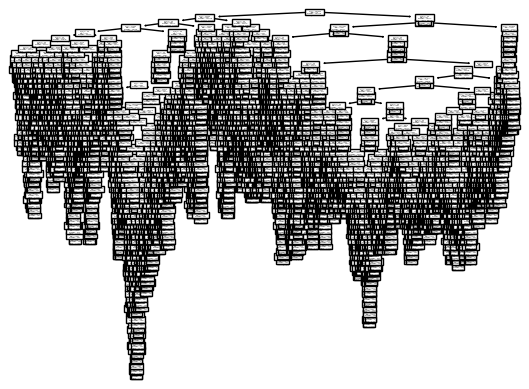

In [17]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
tree.plot_tree(decision_tree)

In [ ]:
print("Accuracy of dt_1 model on test data from test_train_split: ",accuracy_score(decision_tree.predict(X_test),y_test))
print("Accuracy of dt_1 model on validation data from the separate file: ",accuracy_score(decision_tree.predict(X_val),y_val))

y_true = y_val
y_pred = decision_tree.predict(X_val)


print(test_data['is_fraud'].value_counts())
print(confusion_matrix(y_true,y_pred))

In [ ]:
#gpt
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(decision_tree, filled=True, rounded=True)
plt.savefig('decision_tree.png')
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002000F836020> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 